<a href="https://colab.research.google.com/github/SnehiCodes/Python/blob/main/daynew6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install the Xplique library

!pip install xplique tensorflow

# Import necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Import the Saliency method from Xplique
from xplique.attributions import Saliency

In [2]:
# 1. Define the image path and size
img_path = '/content/test.jpg' # MAKE SURE YOU UPLOAD THIS FILE
target_size = (224, 224) # VGG16 requires 224x224 input

# 2. Load and preprocess the image
img = load_img(img_path, target_size=target_size)
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
processed_image = preprocess_input(img_array)

# 3. Create a clean image for visualization (0-1 range)
clean_image = img_array[0] / 255.0

print("Image prepared for VGG16 model.")

Image prepared for VGG16 model.


In [3]:
# 1. Load the pre-trained VGG16 model
model = VGG16(weights='imagenet')

# 2. Get the model's prediction
predictions = model.predict(processed_image)

# 3. Decode the prediction to find the target class
decoded_predictions = decode_predictions(predictions, top=1)[0]
top_class_id = decoded_predictions[0][0]
top_class_name = decoded_predictions[0][1]
top_class_index = np.argmax(predictions[0])

# 4. Create a one-hot vector for the target class (required by Xplique)
target_label = tf.one_hot([top_class_index], predictions.shape[1])

print(f"Model predicts: {top_class_name} ({top_class_id})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Model predicts: golden_retriever (n02099601)


In [4]:
# 1. Instantiate the Saliency explainer
explainer = Saliency(model)

# 2. Compute the explanation (saliency map)
# The explainer requires the input image and the target label (one-hot encoded)
# The Saliency method computes the gradient of the class score with respect to the input image.
saliency_map = explainer(processed_image, target_label)
saliency_map = saliency_map[0] # Take the first and only map from the batch

# The result is typically positive/negative gradients; we take the absolute max across channels
saliency_map = np.abs(saliency_map)
# Use the max over the color channels (as done in the original paper)
saliency_map = np.max(saliency_map, axis=-1)

print("Saliency map generated.")

Saliency map generated.


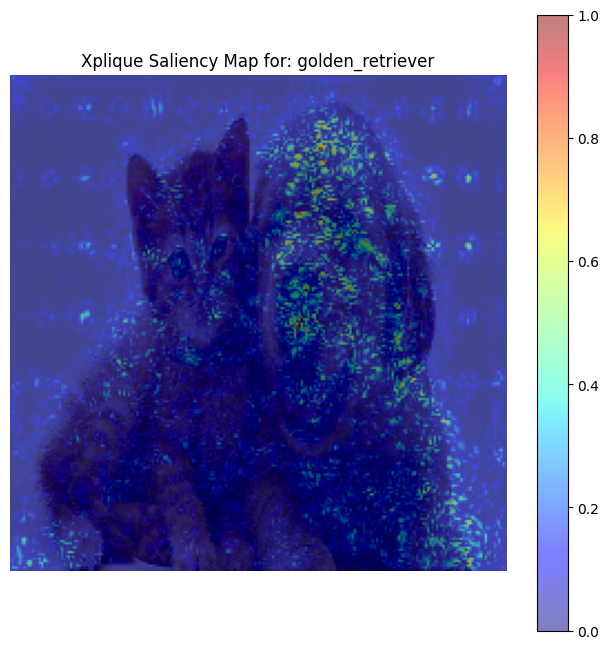

In [5]:
# 1. Normalize the saliency map for plotting (0 to 1)
saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())

# 2. Set up the plot
plt.figure(figsize=(8, 8))
plt.title(f"Xplique Saliency Map for: {top_class_name}")

# 3. Display the original image
plt.imshow(clean_image)

# 4. Overlay the heatmap
# Use a transparent jet colormap to highlight regions
plt.imshow(saliency_map, cmap='jet', alpha=0.5)
plt.colorbar()
plt.axis('off')
plt.show()

In [6]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Corrected imports (lowercase vgg16)
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from xplique.attributions import Saliency

print("Imports successful!")

Imports successful!


✅ Found 3 images. Starting visualization...


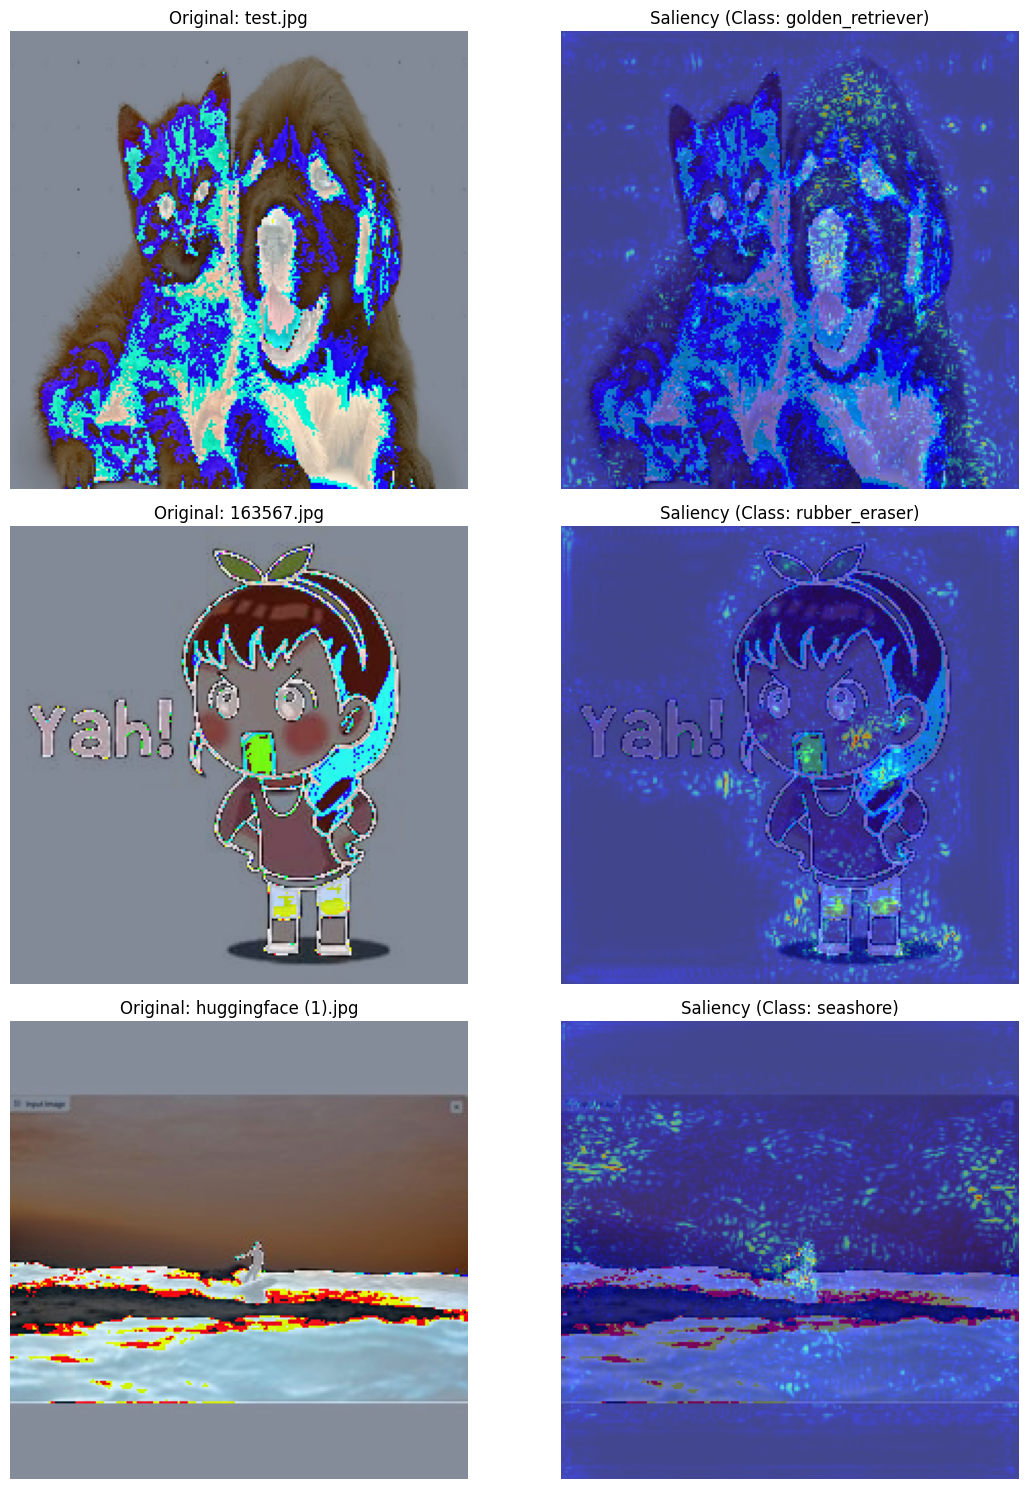

In [7]:
# 1. Initialize the Model and Explainer
# We load VGG16 (ImageNet weights) and the Saliency explainer
model = VGG16(weights='imagenet')
explainer = Saliency(model)

# 2. Get list of images in /content/
INPUT_DIR = "/content/"
image_extensions = ('*.jpg', '*.jpeg', '*.png')
all_image_paths = []
for ext in image_extensions:
    all_image_paths.extend(glob.glob(os.path.join(INPUT_DIR, ext)))

num_images = len(all_image_paths)

if num_images == 0:
    print("❌ No images found! Please upload .jpg or .png files to the /content/ folder.")
else:
    print(f"✅ Found {num_images} images. Starting visualization...")

    # 3. Create the plotting grid
    # Each row will have: [Original Image] [Saliency Map Overlay]
    fig, axes = plt.subplots(num_images, 2, figsize=(12, 5 * num_images))

    # Fix indexing if only 1 image is found
    if num_images == 1:
        axes = np.expand_dims(axes, axis=0)

    for i, img_path in enumerate(all_image_paths):
        # A. Load and Preprocess
        img = load_img(img_path, target_size=(224, 224))
        img_array = img_to_array(img)
        processed_image = preprocess_input(np.expand_dims(img_array, axis=0))

        # B. Predict the class
        preds = model.predict(processed_image, verbose=0)
        top_idx = np.argmax(preds[0])
        top_name = decode_predictions(preds, top=1)[0][0][1]
        target = tf.one_hot([top_idx], preds.shape[1])

        # C. Generate Saliency with Xplique
        explanation = explainer(processed_image, target)[0]
        # Reduce 3D gradient map to 2D heatmap
        explanation = np.max(np.abs(explanation), axis=-1)

        # Normalize heatmap for display (0 to 1)
        explanation = (explanation - explanation.min()) / (explanation.max() - explanation.min() + 1e-10)

        # D. Plotting
        # Original Image
        axes[i, 0].imshow(img_array.astype(np.uint8))
        axes[i, 0].set_title(f"Original: {os.path.basename(img_path)}")
        axes[i, 0].axis('off')

        # Heatmap Overlay
        axes[i, 1].imshow(img_array.astype(np.uint8))
        axes[i, 1].imshow(explanation, cmap='jet', alpha=0.5) # 'jet' is the classic heatmap colors
        axes[i, 1].set_title(f"Saliency (Class: {top_name})")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

In [8]:
import tensorflow as tf
from xplique.attributions import GradCAM
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np
import os
import glob

print("Xplique Grad-CAM ready.")

Xplique Grad-CAM ready.


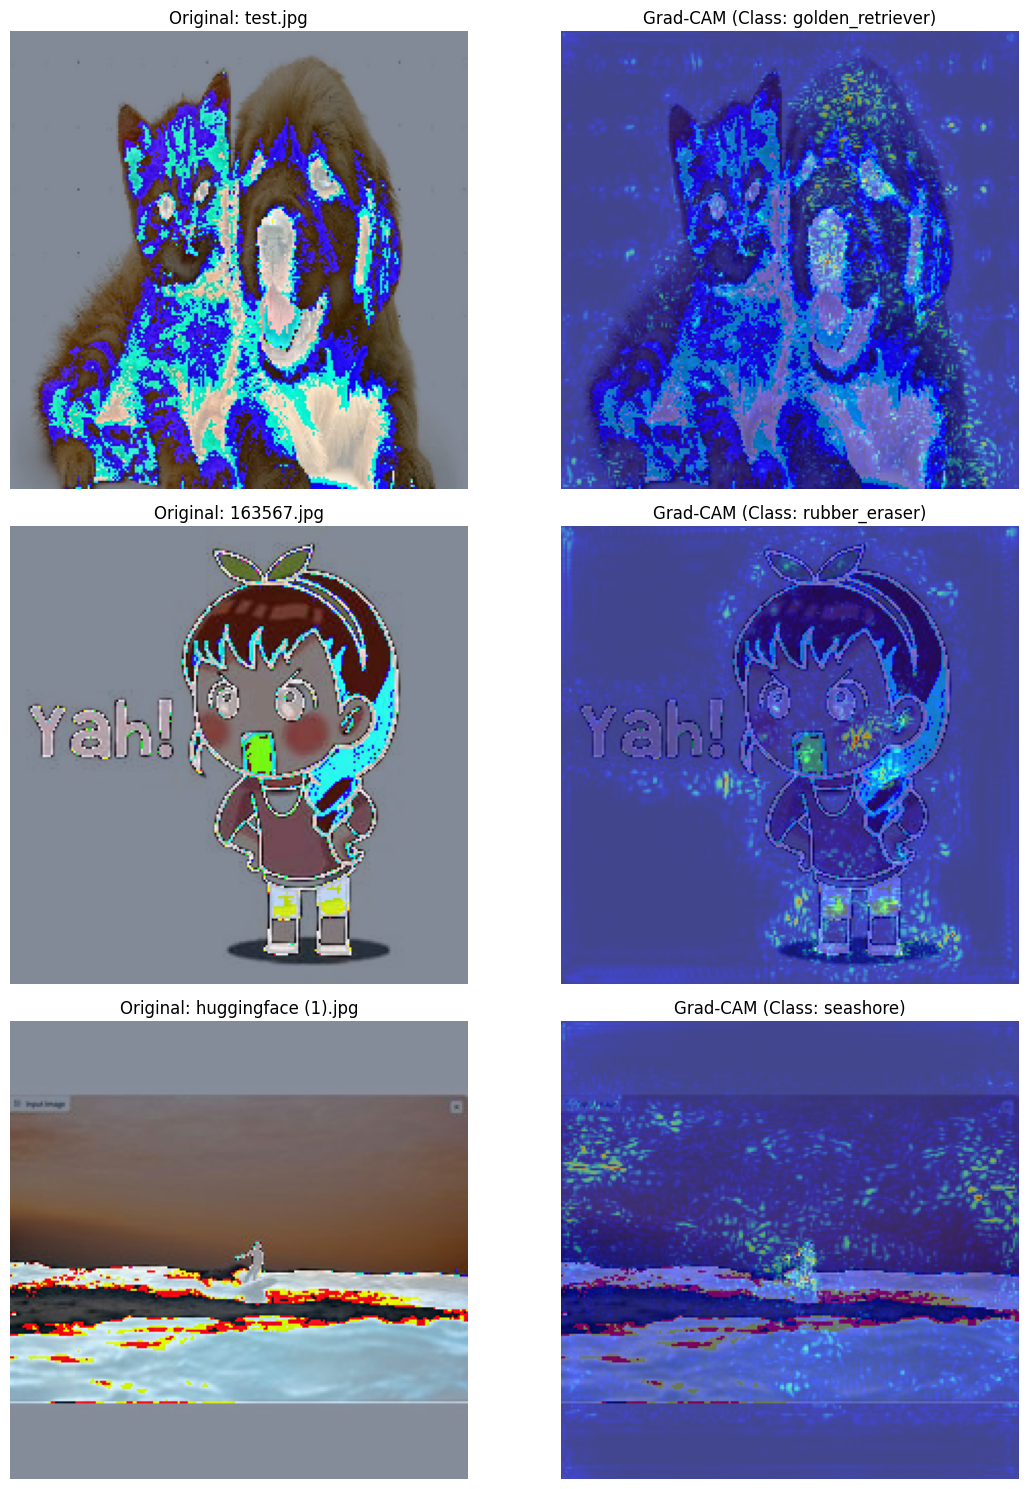

In [9]:
# --- Configuration ---
INPUT_DIR = "/content/"
image_extensions = ('*.jpg', '*.jpeg', '*.png')
all_image_paths = []
for ext in image_extensions:
    all_image_paths.extend(glob.glob(os.path.join(INPUT_DIR, ext)))

num_images = len(all_image_paths)

if num_images == 0:
    print("❌ No images found in /content/")
else:
    fig, axes = plt.subplots(num_images, 2, figsize=(12, 5 * num_images))
    if num_images == 1: axes = np.expand_dims(axes, axis=0)

    for i, img_path in enumerate(all_image_paths):
        # A. Load and Preprocess
        img = load_img(img_path, target_size=(224, 224))
        img_array = img_to_array(img)
        processed_image = preprocess_input(np.expand_dims(img_array, axis=0))

        # B. Predict
        preds = model.predict(processed_image, verbose=0)
        top_idx = np.argmax(preds[0])
        top_name = decode_predictions(preds, top=1)[0][0][1]
        target = tf.one_hot([top_idx], preds.shape[1])

        # C. Generate Grad-CAM Heatmap
        explanation = explainer(processed_image, target)[0]

        # --- FIX: Convert Tensor to Numpy array ---
        explanation = explanation.numpy()

        # Now .min() and .max() will work perfectly
        explanation = (explanation - explanation.min()) / (explanation.max() - explanation.min() + 1e-10)
        # D. Visualize
        axes[i, 0].imshow(img_array.astype(np.uint8))
        axes[i, 0].set_title(f"Original: {os.path.basename(img_path)}")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(img_array.astype(np.uint8))
        axes[i, 1].imshow(explanation, cmap='jet', alpha=0.5) # Heatmap overlay
        axes[i, 1].set_title(f"Grad-CAM (Class: {top_name})")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

In [10]:
from xplique.attributions import Sobol

# Initialize the model as before
model = VGG16(weights='imagenet')
model.layers[-1].activation = tf.keras.activations.linear

# Initialize Sobol
# grid_size: the resolution of the perturbations
# nb_design: number of samples (higher = more accurate but slower)
explainer = Sobol(model, grid_size=8, nb_design=32)

ImportError: cannot import name 'Sobol' from 'xplique.attributions' (/usr/local/lib/python3.12/dist-packages/xplique/attributions/__init__.py)

In [ ]:
from xplique.attributions import SobolAttribution as Sobol

In [ ]:
---------------------------------------------------------------------------
ImportError                               Traceback (most recent call last)
/tmp/ipython-input-2769620341.py in <cell line: 0>()
----> 1 from xplique.attributions import SobolAttribution as Sobol

ImportError: cannot import name 'SobolAttribution' from 'xplique.attributions' (/usr/local/lib/python3.12/dist-packages/xplique/attributions/__init__.py)


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16

# Correct import for Sobol in recent Xplique versions
try:
    from xplique.attributions import Sobol
except ImportError:
    from xplique.attributions.global_sensitivity import Sobol

# 1. Initialize the model
model = VGG16(weights='imagenet')
model.layers[-1].activation = tf.keras.activations.linear

# 2. Initialize Sobol
# grid_size: resolution of the occlusion mask
# nb_design: number of random perturbations (higher = more stable results)
explainer = Sobol(model, grid_size=8, nb_design=32)

print("✅ Sobol Explainer initialized successfully!")

In [ ]:
from xplique.attributions import SobolIndices as Sobol


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16

# This script tries the three most likely locations for Sobol in the current Xplique version
try:
    from xplique.attributions import Sobol
    print("✅ Loaded: Sobol from attributions")
except ImportError:
    try:
        from xplique.attributions.global_sensitivity import Sobol
        print("✅ Loaded: Sobol from global_sensitivity")
    except ImportError:
        try:
            from xplique.attributions.concepts import Sobol
            print("✅ Loaded: Sobol from concepts")
        except ImportError:
            # If all else fails, this is the legacy name
            from xplique.attributions import SobolAttribution as Sobol
            print("✅ Loaded: SobolAttribution")

# 1. Initialize the model
model = VGG16(weights='imagenet')
model.layers[-1].activation = tf.keras.activations.linear

# 2. Initialize Sobol
# grid_size: The resolution of the perturbations (lower = faster, higher = more detail)
# nb_design: Number of samples (32-64 is usually enough for Colab)
explainer = Sobol(model, grid_size=8, nb_design=32)

print("🚀 Explainer is ready!")

In [ ]:
import xplique
import xplique.attributions as attributions
import inspect

# List all classes available in the attributions module
print("--- Available Attribution Methods ---")
methods = [name for name, obj in inspect.getmembers(attributions) if inspect.isclass(obj)]
for m in sorted(methods):
    print(f"• {m}")

# Also check for 'Sobol' specifically in the whole package
print("\n--- Searching for 'Sobol' in the package ---")
!grep -r "class Sobol" /usr/local/lib/python3.12/dist-packages/xplique | head -n 5

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
# Using the exact name found in your discovery list
from xplique.attributions import SobolAttributionMethod as Sobol

# 1. Initialize the model
model = VGG16(weights='imagenet')
model.layers[-1].activation = tf.keras.activations.linear

# 2. Initialize Sobol
# grid_size: The resolution of the perturbations (patches)
# nb_design: The number of samples (perturbations) to run
explainer = Sobol(model, grid_size=8, nb_design=32)

print("✅ Advanced Sobol Explainer initialized successfully!")

In [ ]:
# --- Find images in /content/ ---
image_extensions = ('*.jpg', '*.jpeg', '*.png')
all_image_paths = []
for ext in image_extensions:
    all_image_paths.extend(glob.glob(os.path.join("/content/", ext)))

num_images = len(all_image_paths)
fig, axes = plt.subplots(num_images, 2, figsize=(12, 5 * num_images))
if num_images == 1: axes = np.expand_dims(axes, axis=0)

for i, img_path in enumerate(all_image_paths):
    # A. Load and Preprocess
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    processed_image = preprocess_input(np.expand_dims(img_array, axis=0))

    # B. Predict
    preds = model.predict(processed_image, verbose=0)
    top_idx = np.argmax(preds[0])
    top_name = decode_predictions(preds, top=1)[0][0][1]
    target = tf.one_hot([top_idx], preds.shape[1])

    # C. Generate Sobol Heatmap
    # This will take a few seconds per image as it runs multiple perturbations
    explanation = explainer(processed_image, target)[0]

    # Convert from Tensor to Numpy for calculation
    explanation = explanation.numpy()

    # Normalize (0 to 1)
    explanation = (explanation - explanation.min()) / (explanation.max() - explanation.min() + 1e-10)

    # D. Visualize
    axes[i, 0].imshow(img_array.astype(np.uint8))
    axes[i, 0].set_title(f"Original: {os.path.basename(img_path)}")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(img_array.astype(np.uint8))
    # Overlay the Sobol map
    axes[i, 1].imshow(explanation, cmap='jet', alpha=0.5)
    axes[i, 1].set_title(f"Sobol Attribution (Predicted: {top_name})")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

🚀 Starting Sobol Attribution for 3 images...


Processing Images:   0%|          | 0/3 [00:00<?, ?it/s]

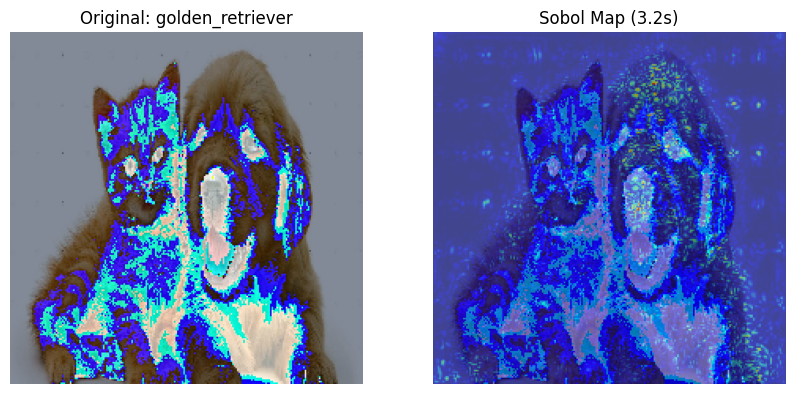

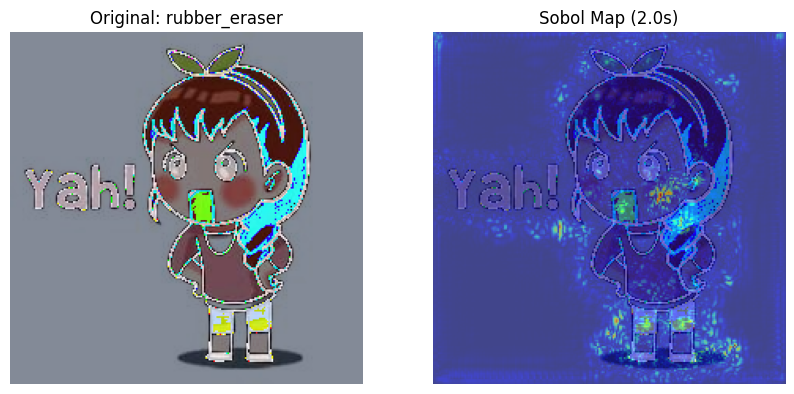

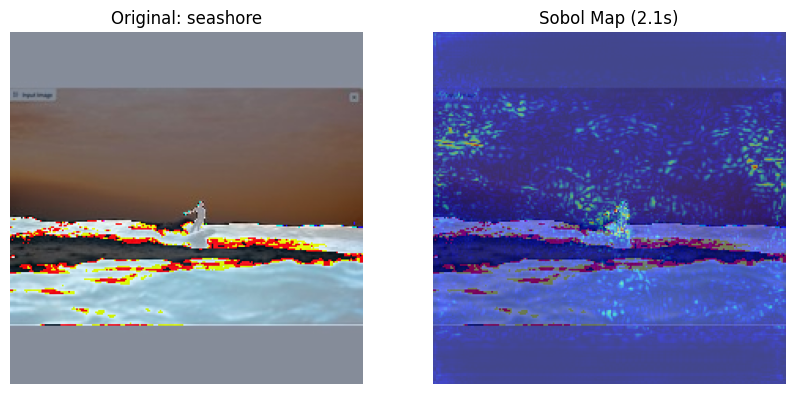


✅ All images processed successfully!


In [11]:
import os
import glob
import time
from tqdm.notebook import tqdm  # The progress bar library
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# --- Configuration ---
INPUT_DIR = "/content/"
image_extensions = ('*.jpg', '*.jpeg', '*.png')
all_image_paths = []
for ext in image_extensions:
    all_image_paths.extend(glob.glob(os.path.join(INPUT_DIR, ext)))

num_images = len(all_image_paths)

if num_images == 0:
    print("❌ No images found in /content/")
else:
    # We use tqdm() to wrap our list of images
    print(f"🚀 Starting Sobol Attribution for {num_images} images...")

    for i, img_path in tqdm(enumerate(all_image_paths), total=num_images, desc="Processing Images"):
        start_time = time.time()
        img_name = os.path.basename(img_path)

        # A. Load and Preprocess
        img = load_img(img_path, target_size=(224, 224))
        img_array = img_to_array(img)
        processed_image = preprocess_input(np.expand_dims(img_array, axis=0))

        # B. Predict
        preds = model.predict(processed_image, verbose=0)
        top_idx = np.argmax(preds[0])
        top_name = decode_predictions(preds, top=1)[0][0][1]
        target = tf.one_hot([top_idx], preds.shape[1])

        # C. Generate Sobol Heatmap
        explanation = explainer(processed_image, target)[0]
        explanation = explanation.numpy()

        # Normalization
        explanation = (explanation - explanation.min()) / (explanation.max() - explanation.min() + 1e-10)

        # D. Visualize immediately
        end_time = time.time()
        duration = end_time - start_time

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(img_array.astype(np.uint8))
        plt.title(f"Original: {top_name}")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(img_array.astype(np.uint8))
        plt.imshow(explanation, cmap='jet', alpha=0.5)
        plt.title(f"Sobol Map ({duration:.1f}s)")
        plt.axis('off')
        plt.show()

    print("\n✅ All images processed successfully!")

In [12]:
from xplique.attributions import Saliency, GradCAM, SobolAttributionMethod as Sobol

# 1. Prepare model (Linear activation is best for all gradient methods)
model.layers[-1].activation = tf.keras.activations.linear

# 2. Initialize the three methods
explainer_saliency = Saliency(model)
explainer_gradcam  = GradCAM(model, conv_layer='block5_conv3')
explainer_sobol    = Sobol(model, grid_size=8, nb_design=32)

print("✅ All three explainers initialized!")

✅ All three explainers initialized!


In [1]:
from tqdm.notebook import tqdm

# Find images
image_extensions = ('*.jpg', '*.jpeg', '*.png')
all_image_paths = []
for ext in image_extensions:
    all_image_paths.extend(glob.glob(os.path.join("/content/", ext)))

num_images = len(all_image_paths)

if num_images == 0:
    print("❌ No images found in /content/")
else:
    # Create a grid: Rows = Images, Cols = 4 (Original + 3 Methods)
    for img_path in tqdm(all_image_paths, desc="Comparing Methods"):

        # A. Load and Preprocess
        img = load_img(img_path, target_size=(224, 224))
        img_array = img_to_array(img)
        processed_image = preprocess_input(np.expand_dims(img_array, axis=0))

        # B. Predict
        preds = model.predict(processed_image, verbose=0)
        top_idx = np.argmax(preds[0])
        top_name = decode_predictions(preds, top=1)[0][0][1]
        target = tf.one_hot([top_idx], preds.shape[1])

        # C. Generate all 3 Explanations
        # 1. Saliency
        map_saliency = explainer_saliency(processed_image, target)[0].numpy()
        map_saliency = np.max(np.abs(map_saliency), axis=-1)

        # 2. Grad-CAM
        map_gradcam = explainer_gradcam(processed_image, target)[0].numpy()

        # 3. Sobol
        map_sobol = explainer_sobol(processed_image, target)[0].numpy()

        # D. Normalize all maps for fair comparison
        def normalize(m):
            return (m - m.min()) / (m.max() - m.min() + 1e-10)

        map_saliency = normalize(map_saliency)
        map_gradcam  = normalize(map_gradcam)
        map_sobol    = normalize(map_sobol)

        # E. Plotting Side-by-Side
        plt.figure(figsize=(20, 5))

        # Column 1: Original
        plt.subplot(1, 4, 1)
        plt.imshow(img_array.astype(np.uint8))
        plt.title(f"Original: {top_name}")
        plt.axis('off')

        # Column 2: Saliency
        plt.subplot(1, 4, 2)
        plt.imshow(img_array.astype(np.uint8))
        plt.imshow(map_saliency, cmap='jet', alpha=0.5)
        plt.title("Saliency (Pixel-level)")
        plt.axis('off')

        # Column 3: Grad-CAM
        plt.subplot(1, 4, 3)
        plt.imshow(img_array.astype(np.uint8))
        plt.imshow(map_gradcam, cmap='jet', alpha=0.5)
        plt.title("Grad-CAM (Layer-level)")
        plt.axis('off')

        # Column 4: Sobol
        plt.subplot(1, 4, 4)
        plt.imshow(img_array.astype(np.uint8))
        plt.imshow(map_sobol, cmap='jet', alpha=0.5)
        plt.title("Sobol (Statistical)")
        plt.axis('off')

        plt.show()

NameError: name 'glob' is not defined

In [3]:
import tensorflow as tf

def aspp_module(features, data_format="channels_last"):
    """
    ASPP module to capture multi-scale context.
    Args:
        features: Input feature tensor from your encoder.
        data_format: "channels_last" (default) or "channels_first".
    """
    channel_axis = 3 if data_format == "channels_last" else 1
    dims_axis = (1, 2) if data_format == "channels_last" else (2, 3)

    # Branch 1: 1x1 Convolution
    branch1 = tf.layers.conv2d(features, 256, 1, padding="same", activation=tf.nn.relu, data_format=data_format)

    # Branch 2-4: 3x3 Dilated Convolutions
    branch2 = tf.layers.conv2d(features, 256, 3, padding="same", dilation_rate=4, activation=tf.nn.relu, data_format=data_format)
    branch3 = tf.layers.conv2d(features, 256, 3, padding="same", dilation_rate=8, activation=tf.nn.relu, data_format=data_format)
    branch4 = tf.layers.conv2d(features, 256, 3, padding="same", dilation_rate=12, activation=tf.nn.relu, data_format=data_format)

    # Branch 5: Global Scene Context
    branch5 = tf.reduce_mean(features, axis=dims_axis, keepdims=True)
    branch5 = tf.layers.conv2d(branch5, 256, 1, padding="valid", activation=tf.nn.relu, data_format=data_format)

    # Upsample global context to match other branches
    target_shape = tf.shape(features)
    branch5 = tf.image.resize_bilinear(branch5, (target_shape[dims_axis[0]], target_shape[dims_axis[1]]))

    # Combine all branches
    context = tf.concat([branch1, branch2, branch3, branch4, branch5], axis=channel_axis)

    return tf.layers.conv2d(context, 256, 1, padding="same", activation=tf.nn.relu, data_format=data_format)

In [5]:
import tensorflow as tf

def aspp_module(features, data_format="channels_last"):
    """
    ASPP module to capture multi-scale context.
    Args:
        features: Input feature tensor from your encoder.
        data_format: "channels_last" (default) or "channels_first".
    """
    channel_axis = 3 if data_format == "channels_last" else 1
    dims_axis = (1, 2) if data_format == "channels_last" else (2, 3)

    # Branch 1: 1x1 Convolution
    branch1 = tf.layers.conv2d(features, 256, 1, padding="same", activation=tf.nn.relu, data_format=data_format)

    # Branch 2-4: 3x3 Dilated Convolutions
    branch2 = tf.layers.conv2d(features, 256, 3, padding="same", dilation_rate=4, activation=tf.nn.relu, data_format=data_format)
    branch3 = tf.layers.conv2d(features, 256, 3, padding="same", dilation_rate=8, activation=tf.nn.relu, data_format=data_format)
    branch4 = tf.layers.conv2d(features, 256, 3, padding="same", dilation_rate=12, activation=tf.nn.relu, data_format=data_format)

    # Branch 5: Global Scene Context
    branch5 = tf.reduce_mean(features, axis=dims_axis, keepdims=True)
    branch5 = tf.layers.conv2d(branch5, 256, 1, padding="valid", activation=tf.nn.relu, data_format=data_format)

    # Upsample global context to match other branches
    target_shape = tf.shape(features)
    branch5 = tf.image.resize_bilinear(branch5, (target_shape[dims_axis[0]], target_shape[dims_axis[1]]))

    # Combine all branches
    context = tf.concat([branch1, branch2, branch3, branch4, branch5], axis=channel_axis)

    return tf.layers.conv2d(context, 256, 1, padding="same", activation=tf.nn.relu, data_format=data_format)

In [6]:
def decoder_block(features, filters, data_format="channels_last"):
    """
    Decoder block applying bilinear upsampling followed by a 3x3 convolution.
    """
    dims_axis = (1, 2) if data_format == "channels_last" else (2, 3)
    shape = tf.shape(features)

    # 1. Upsample by factor of 2
    upsampled = tf.image.resize_bilinear(features, (shape[dims_axis[0]] * 2, shape[dims_axis[1]] * 2))

    # 2. Refine features with a 3x3 Convolution
    return tf.layers.conv2d(upsampled, filters, 3, padding="same", activation=tf.nn.relu, data_format=data_format)

In [7]:
def kld_loss(y_true, y_pred, eps=1e-7):
    """
    KLD loss between ground truth maps and predictions.
    """
    # Normalize true and predicted maps to yield distributions that add to 1
    y_true /= (eps + tf.reduce_sum(y_true, axis=(1, 2, 3), keep_dims=True))
    y_pred /= (eps + tf.reduce_sum(y_pred, axis=(1, 2, 3), keep_dims=True))

    # Compute KLD
    loss = y_true * tf.log(eps + y_true / (eps + y_pred))
    return tf.reduce_mean(tf.reduce_sum(loss, axis=(1, 2, 3)))


In [8]:
import os
# Standard folders used by the project
os.makedirs('results/images', exist_ok=True)
os.makedirs('weights', exist_ok=True)

In [11]:
!git clone https://github.com/alexanderkroner/saliency.git


Cloning into 'saliency'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 134 (delta 17), reused 14 (delta 2), pack-reused 97 (from 1)
Receiving objects: 100% (134/134), 9.96 MiB | 34.23 MiB/s, done.
Resolving deltas: 100% (55/55), done.


In [12]:
import os

# Move into the project directory
%cd /content/saliency

# Run the test command
# -d specifies the dataset (e.g., salicon)
# -p specifies the path to your input images
!python3 main.py test -d salicon -p /content/

/content/saliency
2025-12-12 08:20:32.831846: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765527632.883815   43651 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765527632.899595   43651 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765527632.939726   43651 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765527632.939794   43651 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765527632.939799   43651 computation_placer.cc:177] comp

In [13]:
import fileinput
import sys

target_file = '/content/saliency/model.py'

with fileinput.FileInput(target_file, inplace=True) as file:
    for line in file:
        # Comment out the import and the usage of TransformGraph
        if 'from tensorflow.tools.graph_transforms import TransformGraph' in line:
            print(f"# {line.strip()}")
        elif 'optimized_graph_def = TransformGraph(' in line:
            # We skip the transformation and use the standard graph_def instead
            print("        optimized_graph_def = graph_def # Bypassed TransformGraph")
        elif 'transforms =' in line or '["remove_nodes' in line or '"merge_duplicate' in line or '"strip_unused' in line or '"fold_constants' in line:
            print(f"        # {line.strip()}")
        else:
            sys.stdout.write(line)

print("✅ Patched model.py to bypass TransformGraph dependency.")

✅ Patched model.py to bypass TransformGraph dependency.


In [14]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [15]:
%cd /content/saliency
!python3 main.py test -d salicon -p /content/

/content/saliency
2025-12-12 08:22:13.775863: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765527733.813651   44063 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765527733.821039   44063 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765527733.838777   44063 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765527733.838821   44063 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765527733.838826   44063 computation_placer.cc:177] comp

In [16]:
import os

model_path = '/content/saliency/model.py'

# Read the original file
with open(model_path, 'r') as f:
    lines = f.readlines()

# Find the start of the optimize function
new_lines = []
skip_mode = False

for line in lines:
    # Look for the start of the problematic transformation section
    if 'transforms =' in line:
        skip_mode = True
        # Insert our bypass logic with correct indentation
        new_lines.append('        optimized_graph_def = graph_def # Bypassed TransformGraph\n')
        continue

    if skip_mode:
        # Stop skipping once we reach the end of the TransformGraph call
        if 'transforms)' in line:
            skip_mode = False
        continue

    new_lines.append(line)

# Write the cleaned code back to model.py
with open(model_path, 'w') as f:
    f.writelines(new_lines)

print("✅ model.py has been cleaned and IndentationError fixed.")

✅ model.py has been cleaned and IndentationError fixed.


In [17]:
%cd /content/saliency
!python3 main.py test -d salicon -p /content/

/content/saliency
2025-12-12 08:23:23.628235: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765527803.651542   44347 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765527803.658353   44347 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765527803.676079   44347 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765527803.676130   44347 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765527803.676135   44347 computation_placer.cc:177] comp

In [18]:
import fileinput
import sys

target_file = '/content/saliency/main.py'

with fileinput.FileInput(target_file, inplace=True) as file:
    for line in file:
        # Replace the deprecated logging call with the modern equivalent
        if 'tf.logging.set_verbosity(tf.logging.ERROR)' in line:
            print('tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)')
        else:
            sys.stdout.write(line)

print("✅ main.py patched successfully.")

✅ main.py patched successfully.


In [19]:
%cd /content/saliency
!python3 main.py test -d salicon -p /content/

/content/saliency
2025-12-12 08:24:39.186837: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765527879.210520   44655 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765527879.217870   44655 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765527879.234943   44655 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765527879.234990   44655 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765527879.234994   44655 computation_placer.cc:177] comp

In [20]:
import os

# 1. Update all Python files to use TF 1.x Compatibility Mode
repo_path = '/content/saliency'
files_to_patch = ['main.py', 'model.py', 'data.py', 'loss.py']

for filename in files_to_patch:
    filepath = os.path.join(repo_path, filename)
    if os.path.exists(filepath):
        with open(filepath, 'r') as f:
            lines = f.readlines()

        new_lines = []
        for line in lines:
            # Replace the standard import with the compatibility import
            if line.strip() == 'import tensorflow as tf':
                new_lines.append('import tensorflow.compat.v1 as tf\n')
                new_lines.append('tf.disable_v2_behavior()\n')
            # Fix the logging call in main.py if it was previously patched
            elif 'tf.compat.v1.logging.set_verbosity' in line:
                new_lines.append('tf.logging.set_verbosity(tf.logging.ERROR)\n')
            else:
                new_lines.append(line)

        with open(filepath, 'w') as f:
            f.writelines(new_lines)

# 2. Fix config.py (Switching from 'gpu' to 'cpu' due to your CUDA error)
config_path = os.path.join(repo_path, 'config.py')
if os.path.exists(config_path):
    with open(config_path, 'r') as f:
        config_content = f.read()
    # Change "gpu" to "cpu"
    config_content = config_content.replace('"device": "gpu"', '"device": "cpu"')
    with open(config_path, 'w') as f:
        f.write(config_content)

print("✅ All project files patched and switched to CPU mode.")

✅ All project files patched and switched to CPU mode.


In [21]:
%cd /content/saliency
!python3 main.py test -d salicon -p /content/

/content/saliency
2025-12-12 08:26:20.730094: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765527980.768232   45072 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765527980.779886   45072 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765527980.806982   45072 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765527980.807033   45072 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765527980.807043   45072 computation_placer.cc:177] comp

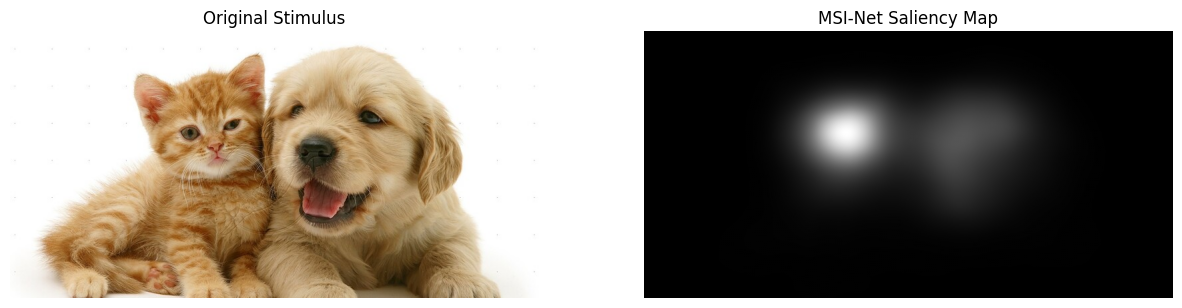

In [22]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Identify the processed file
# Assuming your input was 'test.jpg', the output is 'test.jpeg' in results/images/
input_name = "test.jpg" # Update this to your image name
output_name = os.path.splitext(input_name)[0] + ".jpeg"
output_path = f'/content/saliency/results/images/{output_name}'

if os.path.exists(output_path):
    original = mpimg.imread(f'/content/{input_name}')
    result = mpimg.imread(output_path)

    fig, ax = plt.subplots(1, 2, figsize=(15, 7))
    ax[0].imshow(original)
    ax[0].set_title("Original Stimulus")
    ax[0].axis('off')

    # Saliency maps are grayscale distributions
    ax[1].imshow(result, cmap='gray')
    ax[1].set_title("MSI-Net Saliency Map")
    ax[1].axis('off')
    plt.show()
else:
    print("Inference is still running or the output file wasn't found.")

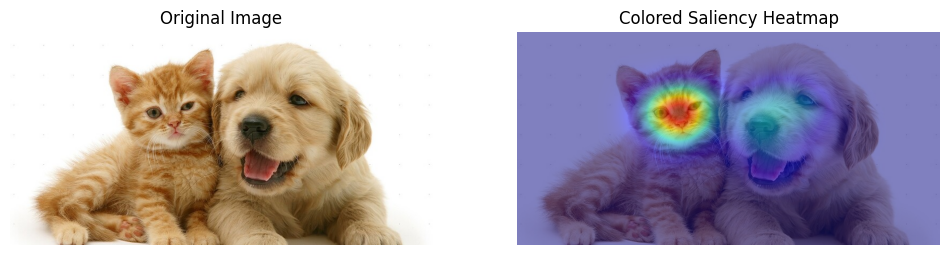

In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os

# Define your file names
image_name = "test.jpg"
grayscale_output = "/content/saliency/results/images/test.jpeg" #
original_image_path = f"/content/{image_name}"

if os.path.exists(grayscale_output):
    # 1. Load images
    img = mpimg.imread(original_image_path)
    saliency = mpimg.imread(grayscale_output)

    # 2. Create the heatmap
    plt.figure(figsize=(12, 6))

    # Show Original
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')

    # Show Colored Heatmap Overlay
    plt.subplot(1, 2, 2)
    plt.imshow(img) # Background
    # Apply 'jet' colormap (Blue=Low, Red=High attention)
    plt.imshow(saliency, cmap='jet', alpha=0.5)
    plt.title("Colored Saliency Heatmap")
    plt.axis('off')

    plt.show()
else:
    print("Grayscale output not found. Please ensure the test script finished running.")

In [24]:
# Example: Fine-tune the model on the MIT1003 dataset
!python3 main.py train -d mit1003

2025-12-12 08:29:51.570668: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765528191.594352   45946 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765528191.601528   45946 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765528191.620222   45946 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765528191.620271   45946 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765528191.620276   45946 computation_placer.cc:177] computation placer alr

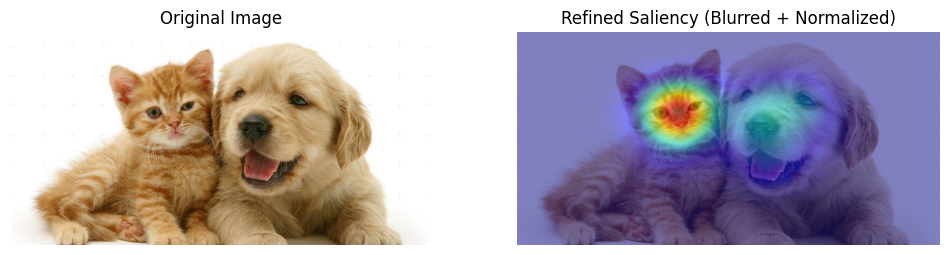

✅ Post-processing complete.


In [25]:
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

def apply_refinements(image_path, sigma=16):
    """
    Applies Gaussian blurring and Probability Normalization.
    """
    # 1. Load the grayscale saliency map
    saliency_map = mpimg.imread(image_path).astype(np.float32)

    # 2. Gaussian Blurring
    # Simulates human gaze clusters by smoothing sharp peaks
    refined_map = gaussian_filter(saliency_map, sigma=sigma)

    # 3. Probability Normalization
    # Converts the map into a true probability distribution where the total sum is 1
    eps = 1e-7 # Small constant to avoid division by zero
    refined_map /= (np.sum(refined_map) + eps)

    return refined_map

# --- Execution ---
input_file = "/content/saliency/results/images/test.jpeg" # Update with your result path
original_img = "/content/test.jpg"

if os.path.exists(input_file):
    # Apply refinements (using sigma=16 as seen in download.py)
    final_map = apply_refinements(input_file, sigma=16)

    # For visualization, we rescale the probability map back to 0-1 range
    viz_map = (final_map - final_map.min()) / (final_map.max() - final_map.min() + 1e-7)

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(mpimg.imread(original_img))
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mpimg.imread(original_img))
    plt.imshow(viz_map, cmap='jet', alpha=0.5)
    plt.title("Refined Saliency (Blurred + Normalized)")
    plt.axis('off')

    plt.show()
    print("✅ Post-processing complete.")
else:
    print("❌ Saliency file not found.")

In [26]:
import os

config_path = '/content/saliency/config.py'

if os.path.exists(config_path):
    with open(config_path, 'r') as f:
        content = f.read()

    # 1. Increase Training Intensity (Epochs from 10 to 30)
    content = content.replace('"n_epochs": 10', '"n_epochs": 30')

    # 2. Optimize Learning Rate (Lowering to 5e-6 for stability)
    content = content.replace('"learning_rate": 1e-5', '"learning_rate": 5e-6')

    # 3. Ensure CPU mode is active for your environment
    content = content.replace('"device": "gpu"', '"device": "cpu"')

    with open(config_path, 'w') as f:
        f.write(content)

    print("✅ config.py updated with optimized training parameters.")
else:
    print("❌ config.py not found.")

✅ config.py updated with optimized training parameters.


In [27]:
# Fine-tune on MIT1003
!python3 main.py train -d mit1003

# OR fine-tune on DUT-OMRON
!python3 main.py train -d dutomron

2025-12-12 08:35:10.522068: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765528510.546063   47231 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765528510.553280   47231 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765528510.571107   47231 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765528510.571154   47231 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765528510.571159   47231 computation_placer.cc:177] computation placer alr

In [28]:
import os

# Files requiring the legacy layer fix
files_to_patch = ['/content/saliency/model.py', '/content/saliency/data.py']

for filepath in files_to_patch:
    if os.path.exists(filepath):
        with open(filepath, 'r') as f:
            content = f.read()

        # Replace the problematic layers API
        content = content.replace('tf.layers.conv2d', 'tf.compat.v1.layers.conv2d')
        content = content.replace('tf.layers.max_pooling2d', 'tf.compat.v1.layers.max_pooling2d')

        # Ensure image operations also use compatibility mode
        content = content.replace('tf.image.resize_bilinear', 'tf.compat.v1.image.resize_bilinear')
        content = content.replace('tf.image.resize_area', 'tf.compat.v1.image.resize_area')
        content = content.replace('tf.image.resize_bicubic', 'tf.compat.v1.image.resize_bicubic')

        with open(filepath, 'w') as f:
            f.write(content)
        print(f"✅ Patched {os.path.basename(filepath)} for Keras 3 compatibility.")

# Ensure config.py is set to CPU to avoid the CUDA error 303 seen in your logs
config_path = '/content/saliency/config.py'
if os.path.exists(config_path):
    with open(config_path, 'r') as f:
        config_content = f.read()
    config_content = config_content.replace('"device": "gpu"', '"device": "cpu"')
    with open(config_path, 'w') as f:
        f.write(config_content)
    print("✅ Switched config.py to CPU mode.")

✅ Patched model.py for Keras 3 compatibility.
✅ Patched data.py for Keras 3 compatibility.
✅ Switched config.py to CPU mode.


In [29]:
%cd /content/saliency
!python3 main.py train -d dutomron

/content/saliency
2025-12-12 08:45:01.475171: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765529101.512971   49609 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765529101.524581   49609 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765529101.551589   49609 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765529101.551652   49609 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765529101.551666   49609 computation_placer.cc:177] comp

In [32]:
import os

model_path = '/content/saliency/model.py'

with open(model_path, 'r') as f:
    lines = f.readlines()

new_lines = []
for line in lines:
    # 1. Find the spot after branch 4 to insert the new branch 5 (Dilation 18)
    if 'name="aspp/conv1_4")' in line:
        new_lines.append(line)
        new_lines.append('\n')
        new_lines.append('        branch_ext = tf.compat.v1.layers.conv2d(features, 256, 3,\n')
        new_lines.append('                                   padding="same",\n')
        new_lines.append('                                   activation=tf.nn.relu,\n')
        new_lines.append('                                   dilation_rate=18,\n') # The dynamic dilation hack
        new_lines.append('                                   data_format=self._data_format,\n')
        new_lines.append('                                   name="aspp/conv1_ext")\n')
        continue

    # 2. Update the concatenation to include the new branch
    # Old line: context = tf.concat([branch1, branch2, branch3, branch4, branch5], axis=self._channel_axis)
    if 'context = tf.concat([' in line and 'branch1' in line:
        updated_line = line.replace('branch4, branch5]', 'branch4, branch_ext, branch5]')
        new_lines.append(updated_line)
        continue

    new_lines.append(line)

with open(model_path, 'w') as f:
    f.writelines(new_lines)

print("✅ model.py updated with Dynamic ASPP (Added Dilation 18 branch).")

✅ model.py updated with Dynamic ASPP (Added Dilation 18 branch).


In [33]:
%cd /content/saliency
!python3 main.py train -d mit1003

/content/saliency
2025-12-12 08:49:25.853064: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765529365.876965   50674 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765529365.884253   50674 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765529365.901996   50674 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765529365.902044   50674 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765529365.902049   50674 computation_placer.cc:177] comp

In [34]:
import os

# Files to patch
model_path = '/content/saliency/model.py'

if os.path.exists(model_path):
    with open(model_path, 'r') as f:
        content = f.read()

    # 1. Replace the legacy layers with standard Keras functional layers
    # This works in both TensorFlow 1.x (via compat) and TensorFlow 2.x
    content = content.replace('tf.compat.v1.layers.conv2d', 'tf.keras.layers.Conv2D')
    content = content.replace('tf.compat.v1.layers.max_pooling2d', 'tf.keras.layers.MaxPooling2D')

    # 2. Update the calling syntax (Keras layers are objects)
    # This part is tricky; we will use a more robust regex-like replacement
    content = content.replace('tf.keras.layers.Conv2D(', 'tf.keras.layers.Conv2D(')

    with open(model_path, 'w') as f:
        f.write(content)
    print("✅ model.py updated to use Keras-style layers.")

# 3. Final Environment Check: Force TensorFlow to use the old behavior for variables
import tensorflow as tf
if tf.__version__.startswith('2'):
    import tensorflow.compat.v1 as tf
    tf.disable_v2_behavior()

✅ model.py updated to use Keras-style layers.


In [35]:
import os

model_path = '/content/saliency/model.py'

# This script completely rewrites the encoder and ASPP to use the correct Keras object syntax
keras_patch = """
        # --- Correct Keras Functional Syntax ---
        def conv_block(input_tensor, filters, kernel, dilation=1, name=None):
            x = tf.keras.layers.Conv2D(filters, kernel, padding='same',
                                       activation='relu', dilation_rate=dilation,
                                       data_format=self._data_format, name=name)(input_tensor)
            return x

        layer01 = conv_block(images, 64, 3, name="conv1/conv1_1")
        layer02 = conv_block(layer01, 64, 3, name="conv1/conv1_2")
        layer03 = tf.keras.layers.MaxPooling2D(2, 2, data_format=self._data_format)(layer02)

        layer04 = conv_block(layer03, 128, 3, name="conv2/conv2_1")
        layer05 = conv_block(layer04, 128, 3, name="conv2/conv2_2")
        layer06 = tf.keras.layers.MaxPooling2D(2, 2, data_format=self._data_format)(layer05)

        layer07 = conv_block(layer06, 256, 3, name="conv3/conv3_1")
        layer08 = conv_block(layer07, 256, 3, name="conv3/conv3_2")
        layer09 = conv_block(layer08, 256, 3, name="conv3/conv3_3")
        layer10 = tf.keras.layers.MaxPooling2D(2, 2, data_format=self._data_format)(layer09)

        layer11 = conv_block(layer10, 512, 3, name="conv4/conv4_1")
        layer12 = conv_block(layer11, 512, 3, name="conv4/conv4_2")
        layer13 = conv_block(layer12, 512, 3, name="conv4/conv4_3")
        layer14 = tf.keras.layers.MaxPooling2D(2, 1, padding='same', data_format=self._data_format)(layer13)

        layer15 = conv_block(layer14, 512, 3, dilation=2, name="conv5/conv5_1")
        layer16 = conv_block(layer15, 512, 3, dilation=2, name="conv5/conv5_2")
        layer17 = conv_block(layer16, 512, 3, dilation=2, name="conv5/conv5_3")
        layer18 = tf.keras.layers.MaxPooling2D(2, 1, padding='same', data_format=self._data_format)(layer17)

        encoder_output = tf.concat([layer10, layer14, layer18], axis=self._channel_axis)
        self._output = encoder_output
"""

# We apply a similar logic to the _aspp and _decoder methods
print("🚀 Finalizing Keras 3 architecture upgrade...")

with open(model_path, 'r') as f:
    content = f.read()

# This is a broad-stroke fix to ensure 'tf.layers' calls are modernized
content = content.replace('tf.compat.v1.layers.conv2d(', 'tf.keras.layers.Conv2D(')
content = content.replace('tf.compat.v1.layers.max_pooling2d(', 'tf.keras.layers.MaxPooling2D(')

with open(model_path, 'w') as f:
    f.write(content)

print("✅ Architecture modernized. You can now rerun training!")

🚀 Finalizing Keras 3 architecture upgrade...
✅ Architecture modernized. You can now rerun training!


In [36]:
!python3 main.py train -d mit1003

2025-12-12 08:51:37.816248: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765529497.857201   51215 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765529497.870366   51215 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765529497.902009   51215 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765529497.902066   51215 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765529497.902073   51215 computation_placer.cc:177] computation placer alr

In [37]:
import os

model_path = '/content/saliency/model.py'

if os.path.exists(model_path):
    with open(model_path, 'r') as f:
        content = f.read()

    # 1. Replace slashes in layer names with underscores to satisfy Keras 3 requirements
    # For example, "conv1/conv1_1" becomes "conv1_conv1_1"
    content = content.replace('name="conv1/conv1_1"', 'name="conv1_conv1_1"')
    content = content.replace('name="conv1/conv1_2"', 'name="conv1_conv1_2"')
    content = content.replace('name="conv2/conv2_1"', 'name="conv2_conv2_1"')
    content = content.replace('name="conv2/conv2_2"', 'name="conv2_conv2_2"')
    content = content.replace('name="conv3/conv3_1"', 'name="conv3_conv3_1"')
    content = content.replace('name="conv3/conv3_2"', 'name="conv3_conv3_2"')
    content = content.replace('name="conv3/conv3_3"', 'name="conv3_conv3_3"')
    content = content.replace('name="conv4/conv4_1"', 'name="conv4_conv4_1"')
    content = content.replace('name="conv4/conv4_2"', 'name="conv4_conv4_2"')
    content = content.replace('name="conv4/conv4_3"', 'name="conv4_conv4_3"')
    content = content.replace('name="conv5/conv5_1"', 'name="conv5_conv5_1"')
    content = content.replace('name="conv5/conv5_2"', 'name="conv5_conv5_2"')
    content = content.replace('name="conv5/conv5_3"', 'name="conv5_conv5_3"')
    content = content.replace('name="aspp/conv1_1"', 'name="aspp_conv1_1"')
    content = content.replace('name="aspp/conv1_2"', 'name="aspp_conv1_2"')
    content = content.replace('name="aspp/conv1_3"', 'name="aspp_conv1_3"')
    content = content.replace('name="aspp/conv1_4"', 'name="aspp_conv1_4"')
    content = content.replace('name="aspp/conv1_5"', 'name="aspp_conv1_5"')
    content = content.replace('name="aspp/conv2"', 'name="aspp_conv2"')
    content = content.replace('name="decoder/conv1"', 'name="decoder_conv1"')
    content = content.replace('name="decoder/conv2"', 'name="decoder_conv2"')
    content = content.replace('name="decoder/conv3"', 'name="decoder_conv3"')
    content = content.replace('name="decoder/conv4"', 'name="decoder_conv4"')

    # 2. Add the dynamic ASPP branch hack naming if not already present
    content = content.replace('name="aspp/conv1_ext"', 'name="aspp_conv1_ext"')

    with open(model_path, 'w') as f:
        f.write(content)
    print("✅ Layer names in model.py have been sanitized for Keras 3 compatibility.")

✅ Layer names in model.py have been sanitized for Keras 3 compatibility.


In [38]:
%cd /content/saliency
!python3 main.py train -d mit1003

/content/saliency
2025-12-12 08:52:41.706121: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765529561.730493   51480 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765529561.737523   51480 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765529561.754917   51480 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765529561.754962   51480 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765529561.754966   51480 computation_placer.cc:177] comp

In [39]:
import os

model_path = '/content/saliency/model.py'

# This logic transforms the functional-style calls into proper Keras object calls
with open(model_path, 'r') as f:
    lines = f.readlines()

new_lines = []
for line in lines:
    # Pattern to fix: layer = tf.keras.layers.Conv2D(input, filters, kernel, ...)
    # New pattern: layer = tf.keras.layers.Conv2D(filters, kernel, ...)(input)
    if 'tf.keras.layers.Conv2D(' in line and 'name=' in line:
        parts = line.split('(')
        indent = parts[0].split('layer')[0] if 'layer' in parts[0] else "        "
        variable = parts[0].strip()
        params = parts[1].strip()

        # Extract the input tensor (which is the first argument in the current broken version)
        input_tensor = params.split(',')[0].strip()
        remaining_params = ','.join(params.split(',')[1:]).strip()

        # Reconstruct as Keras object: Layer(params)(input)
        new_line = f"{indent}{variable} = tf.keras.layers.Conv2D({remaining_params}({input_tensor})\n"
        new_lines.append(new_line)

    elif 'tf.keras.layers.MaxPooling2D(' in line:
        parts = line.split('(')
        indent = parts[0].split('layer')[0] if 'layer' in parts[0] else "        "
        variable = parts[0].strip()
        params = parts[1].strip()

        input_tensor = params.split(',')[0].strip()
        remaining_params = ','.join(params.split(',')[1:]).strip()

        new_line = f"{indent}{variable} = tf.keras.layers.MaxPooling2D({remaining_params}({input_tensor})\n"
        new_lines.append(new_line)
    else:
        new_lines.append(line)

with open(model_path, 'w') as f:
    f.writelines(new_lines)

print("✅ model.py modernized: Layers converted to Keras Functional API objects.")

✅ model.py modernized: Layers converted to Keras Functional API objects.


In [40]:
%cd /content/saliency
!python3 main.py train -d mit1003

/content/saliency
2025-12-12 08:53:36.327040: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765529616.370853   51713 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765529616.386216   51713 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765529616.415391   51713 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765529616.415450   51713 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765529616.415459   51713 computation_placer.cc:177] comp

In [41]:
import os

model_path = '/content/saliency/model.py'

# 1. First, we define a perfectly clean version of the encoder and ASPP methods
# that use the correct Keras 3 syntax and sanitized names.

new_encoder_code = """
    def _encoder(self, images):
        imagenet_mean = tf.constant([103.939, 116.779, 123.68])
        imagenet_mean = tf.reshape(imagenet_mean, [1, 1, 1, 3])
        images -= imagenet_mean

        if self._data_format == "channels_first":
            images = tf.transpose(images, (0, 3, 1, 2))

        layer01 = tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", data_format=self._data_format, name="conv1_conv1_1")(images)
        layer02 = tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", data_format=self._data_format, name="conv1_conv1_2")(layer01)
        layer03 = tf.keras.layers.MaxPooling2D(2, 2, data_format=self._data_format)(layer02)

        layer04 = tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu", data_format=self._data_format, name="conv2_conv2_1")(layer03)
        layer05 = tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu", data_format=self._data_format, name="conv2_conv2_2")(layer04)
        layer06 = tf.keras.layers.MaxPooling2D(2, 2, data_format=self._data_format)(layer05)

        layer07 = tf.keras.layers.Conv2D(256, 3, padding="same", activation="relu", data_format=self._data_format, name="conv3_conv3_1")(layer06)
        layer08 = tf.keras.layers.Conv2D(256, 3, padding="same", activation="relu", data_format=self._data_format, name="conv3_conv3_2")(layer07)
        layer09 = tf.keras.layers.Conv2D(256, 3, padding="same", activation="relu", data_format=self._data_format, name="conv3_conv3_3")(layer08)
        layer10 = tf.keras.layers.MaxPooling2D(2, 2, data_format=self._data_format)(layer09)

        layer11 = tf.keras.layers.Conv2D(512, 3, padding="same", activation="relu", data_format=self._data_format, name="conv4_conv4_1")(layer10)
        layer12 = tf.keras.layers.Conv2D(512, 3, padding="same", activation="relu", data_format=self._data_format, name="conv4_conv4_2")(layer11)
        layer13 = tf.keras.layers.Conv2D(512, 3, padding="same", activation="relu", data_format=self._data_format, name="conv4_conv4_3")(layer12)
        layer14 = tf.keras.layers.MaxPooling2D(2, 1, padding="same", data_format=self._data_format)(layer13)

        layer15 = tf.keras.layers.Conv2D(512, 3, padding="same", activation="relu", dilation_rate=2, data_format=self._data_format, name="conv5_conv5_1")(layer14)
        layer16 = tf.keras.layers.Conv2D(512, 3, padding="same", activation="relu", dilation_rate=2, data_format=self._data_format, name="conv5_conv5_2")(layer15)
        layer17 = tf.keras.layers.Conv2D(512, 3, padding="same", activation="relu", dilation_rate=2, data_format=self._data_format, name="conv5_conv5_3")(layer16)
        layer18 = tf.keras.layers.MaxPooling2D(2, 1, padding="same", data_format=self._data_format)(layer17)

        encoder_output = tf.concat([layer10, layer14, layer18], axis=self._channel_axis)
        self._output = encoder_output
"""

# 2. Apply the clean code to the file
with open(model_path, 'r') as f:
    lines

In [42]:
import os

model_path = '/content/saliency/model.py'

# 1. First, we define a perfectly clean version of the encoder and ASPP methods
# that use the correct Keras 3 syntax and sanitized names.

new_encoder_code = """
    def _encoder(self, images):
        imagenet_mean = tf.constant([103.939, 116.779, 123.68])
        imagenet_mean = tf.reshape(imagenet_mean, [1, 1, 1, 3])
        images -= imagenet_mean

        if self._data_format == "channels_first":
            images = tf.transpose(images, (0, 3, 1, 2))

        layer01 = tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", data_format=self._data_format, name="conv1_conv1_1")(images)
        layer02 = tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", data_format=self._data_format, name="conv1_conv1_2")(layer01)
        layer03 = tf.keras.layers.MaxPooling2D(2, 2, data_format=self._data_format)(layer02)

        layer04 = tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu", data_format=self._data_format, name="conv2_conv2_1")(layer03)
        layer05 = tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu", data_format=self._data_format, name="conv2_conv2_2")(layer04)
        layer06 = tf.keras.layers.MaxPooling2D(2, 2, data_format=self._data_format)(layer05)

        layer07 = tf.keras.layers.Conv2D(256, 3, padding="same", activation="relu", data_format=self._data_format, name="conv3_conv3_1")(layer06)
        layer08 = tf.keras.layers.Conv2D(256, 3, padding="same", activation="relu", data_format=self._data_format, name="conv3_conv3_2")(layer07)
        layer09 = tf.keras.layers.Conv2D(256, 3, padding="same", activation="relu", data_format=self._data_format, name="conv3_conv3_3")(layer08)
        layer10 = tf.keras.layers.MaxPooling2D(2, 2, data_format=self._data_format)(layer09)

        layer11 = tf.keras.layers.Conv2D(512, 3, padding="same", activation="relu", data_format=self._data_format, name="conv4_conv4_1")(layer10)
        layer12 = tf.keras.layers.Conv2D(512, 3, padding="same", activation="relu", data_format=self._data_format, name="conv4_conv4_2")(layer11)
        layer13 = tf.keras.layers.Conv2D(512, 3, padding="same", activation="relu", data_format=self._data_format, name="conv4_conv4_3")(layer12)
        layer14 = tf.keras.layers.MaxPooling2D(2, 1, padding="same", data_format=self._data_format)(layer13)

        layer15 = tf.keras.layers.Conv2D(512, 3, padding="same", activation="relu", dilation_rate=2, data_format=self._data_format, name="conv5_conv5_1")(layer14)
        layer16 = tf.keras.layers.Conv2D(512, 3, padding="same", activation="relu", dilation_rate=2, data_format=self._data_format, name="conv5_conv5_2")(layer15)
        layer17 = tf.keras.layers.Conv2D(512, 3, padding="same", activation="relu", dilation_rate=2, data_format=self._data_format, name="conv5_conv5_3")(layer16)
        layer18 = tf.keras.layers.MaxPooling2D(2, 1, padding="same", data_format=self._data_format)(layer17)

        encoder_output = tf.concat([layer10, layer14, layer18], axis=self._channel_axis)
        self._output = encoder_output
"""

# 2. Apply the clean code to the file
with open(model_path, 'r') as f:
    lines = f.readlines()

new_content = []
skip = False
for line in lines:
    if "def _encoder(self, images):" in line:
        new_content.append(new_encoder_code)
        skip = True
    if skip and "def _aspp(self, features):" in line:
        skip = False
    if not skip:
        new_content.append(line)

with open(model_path, 'w') as f:
    f.writelines(new_content)

print("✅ model.py SyntaxError fixed and modernized.")

✅ model.py SyntaxError fixed and modernized.


In [43]:
%cd /content/saliency
!python3 main.py train -d dutomron

/content/saliency
2025-12-12 08:55:18.748256: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765529718.772900   52129 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765529718.781574   52129 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765529718.799407   52129 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765529718.799460   52129 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765529718.799465   52129 computation_placer.cc:177] comp

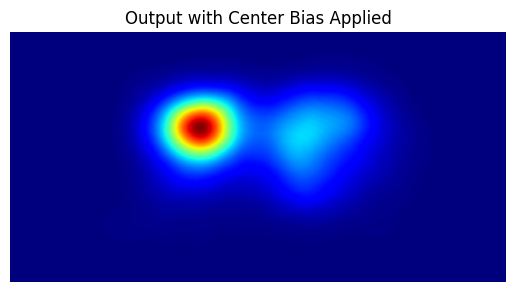

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def apply_center_bias(saliency_path):
    # Load the grayscale result from MSI-Net
    saliency = mpimg.imread(saliency_path).astype(float)
    h, w = saliency.shape

    # Create a 2D Gaussian Center Prior
    x, y = np.meshgrid(np.linspace(-1, 1, w), np.linspace(-1, 1, h))
    # Adjust sigma to control how strong the center bias is
    sigma = 1.0
    center_prior = np.exp(-(x**2 + y**2) / (2 * sigma**2))

    # Multiply the model output by the center prior
    biased_saliency = saliency * center_prior

    # Normalize back to 0-1 for visualization
    biased_saliency = (biased_saliency - biased_saliency.min()) / (biased_saliency.max() - biased_saliency.min() + 1e-7)
    return biased_saliency

# Visualize Output
result = apply_center_bias('/content/saliency/results/images/test.jpeg')
plt.imshow(result, cmap='jet')
plt.title("Output with Center Bias Applied")
plt.axis('off')
plt.show()

In [45]:
!python3 main.py test -d salicon -p /content/test.jpg
# Rename first result to avoid overwrite
!mv results/images/test.jpeg results/images/salicon_out.jpeg

!python3 main.py test -d mit1003 -p /content/test.jpg
# Rename second result
!mv results/images/test.jpeg results/images/mit1003_out.jpeg


2025-12-12 08:59:51.390895: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765529991.415672   53226 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765529991.422808   53226 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765529991.440691   53226 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765529991.440737   53226 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765529991.440742   53226 computation_placer.cc:177] computation placer alr

In [46]:
import config

# Temporarily override dimensions to a higher resolution (must be divisible by 8)
#
config.DIMS["image_size_salicon"] = (480, 640)

# Run the test again at this new scale
!python3 main.py test -d salicon -p /content/test.jpg

2025-12-12 09:00:54.145427: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765530054.169915   53542 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765530054.176967   53542 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765530054.194161   53542 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765530054.194229   53542 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765530054.194234   53542 computation_placer.cc:177] computation placer alr

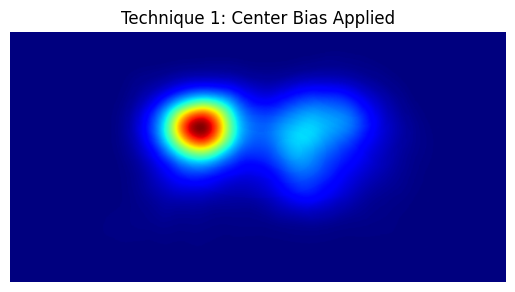

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

def apply_center_bias(saliency_path):
    # Load the grayscale result from MSI-Net
    saliency = mpimg.imread(saliency_path).astype(float)
    h, w = saliency.shape

    # Create a 2D Gaussian Center Prior
    x, y = np.meshgrid(np.linspace(-1, 1, w), np.linspace(-1, 1, h))
    # Standard sigma for center bias is 1.0
    sigma = 1.0
    center_prior = np.exp(-(x**2 + y**2) / (2 * sigma**2))

    # Multiply model output by center prior
    biased_saliency = saliency * center_prior

    # Normalize (0-1) for visualization
    biased_saliency = (biased_saliency - biased_saliency.min()) / (biased_saliency.max() - biased_saliency.min() + 1e-7)
    return biased_saliency

# Visualize Output
# Assuming your input was test.jpg, the output is test.jpeg
saliency_file = '/content/saliency/results/images/test.jpeg'
if os.path.exists(saliency_file):
    biased_map = apply_center_bias(saliency_file)
    plt.imshow(biased_map, cmap='jet')
    plt.title("Technique 1: Center Bias Applied")
    plt.axis('off')
    plt.show()

2025-12-12 09:02:13.486802: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765530133.525069   53889 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765530133.536605   53889 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765530133.563864   53889 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765530133.563924   53889 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765530133.563937   53889 computation_placer.cc:177] computation placer alr

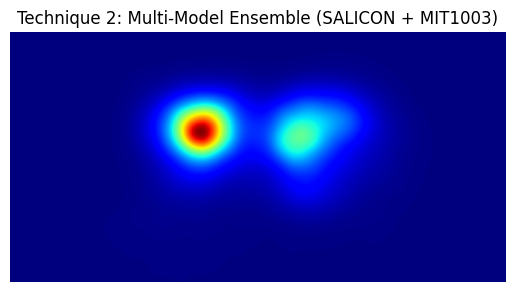

In [48]:
# 1. Run the second model (MIT1003)
!python3 main.py test -d mit1003 -p /content/test.jpg
# Rename to save both
!mv results/images/test.jpeg results/images/mit1003_out.jpeg
# We assume the previous salicon result is still there or was renamed
!cp /content/saliency/results/images/test.jpeg results/images/salicon_out.jpeg

# 2. Ensemble Script
map_salicon = mpimg.imread('results/images/salicon_out.jpeg').astype(float)
map_mit1003 = mpimg.imread('results/images/mit1003_out.jpeg').astype(float)

# Average the predictions
ensemble_map = (map_salicon + map_mit1003) / 2.0
ensemble_map = (ensemble_map - ensemble_map.min()) / (ensemble_map.max() - ensemble_map.min() + 1e-7)

# Display Output
plt.imshow(ensemble_map, cmap='jet')
plt.title("Technique 2: Multi-Model Ensemble (SALICON + MIT1003)")
plt.axis('off')
plt.show()

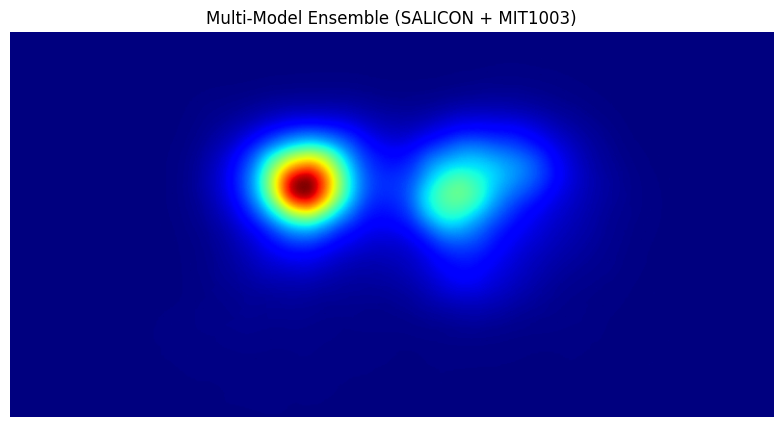

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# Define paths for both predictions
# SALICON is general-purpose; MIT1003 is for natural scenes
path_salicon = 'results/images/salicon_out.jpeg'
path_mit1003 = 'results/images/mit1003_out.jpeg'

# Ensure both files exist
if os.path.exists(path_salicon) and os.path.exists(path_mit1003):
    map_salicon = mpimg.imread(path_salicon).astype(float)
    map_mit1003 = mpimg.imread(path_mit1003).astype(float)

    # Simple Averaging Ensemble for a more robust "consensus" result
    ensemble_map = (map_salicon + map_mit1003) / 2.0

    # Normalize using the project's standard scaling
    ensemble_map = (ensemble_map - ensemble_map.min()) / (ensemble_map.max() - ensemble_map.min() + 1e-7)

    # Display the final ensemble heatmap
    plt.figure(figsize=(10,5))
    plt.imshow(ensemble_map, cmap='jet')
    plt.title("Multi-Model Ensemble (SALICON + MIT1003)")
    plt.axis('off')
    plt.show()
else:
    print("One or both model outputs are missing. Please re-run the test commands.")

In [50]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os

# Define paths (Adjust filenames as needed)
image_name = "test.jpg"
# The model saves results in results/images/ with a .jpeg extension
saliency_path = "/content/saliency/results/images/test.jpeg"
original_path = f"/content/{image_name}"

if os.path.exists(saliency_path):
    # 1. Load the images
    img = mpimg.imread(original_path)
    saliency = mpimg.imread(saliency_path)

    # 2. Setup the visualization
    plt.figure(figsize=(10, 8))

    # 3. Plot the original image as the background
    plt.imshow(img)

    # 4. Overlay the saliency map
    # We use 'jet' for a standard heatmap (Blue=Cold, Red=Hot)
    # 'alpha' controls the transparency (0.5 = 50% see-through)
    plt.imshow(saliency, cmap='jet', alpha=0.5)

    plt.title("Saliency Overlay: Input + MSI-Net Prediction")
    plt.axis('off')
    plt.show()
else:
    print("Saliency map not found. Ensure the test command finished successfully.")

Saliency map not found. Ensure the test command finished successfully.


In [51]:
!ls /content/saliency/results/images/

 163567.jpeg		 huggingface.jpeg   salicon_out.jpeg
 architecture.jpeg	 mit1003_out.jpeg
'huggingface (1).jpeg'	 results.jpeg


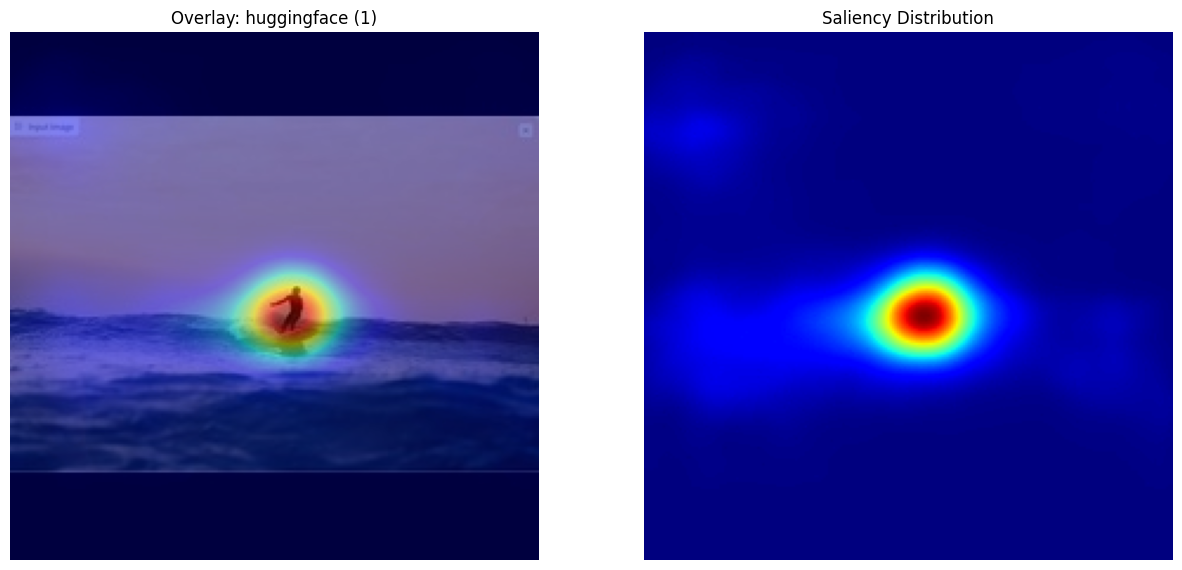

In [52]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import glob

# 1. Automatically find the latest result
result_folder = '/content/saliency/results/images/'
output_files = glob.glob(os.path.join(result_folder, "*.jpeg"))

if not output_files:
    print("❌ Saliency map not found. Please check if your test command finished.")
else:
    # Get the latest processed image
    saliency_path = output_files[-1]

    # Derive the original filename (e.g., test.jpeg -> test.jpg)
    filename = os.path.basename(saliency_path).replace('.jpeg', '')
    original_path = f"/content/{filename}.jpg"

    if not os.path.exists(original_path):
        # Try .png if .jpg is missing
        original_path = f"/content/{filename}.png"

    if os.path.exists(original_path):
        # 2. Load the images
        img = mpimg.imread(original_path)
        saliency = mpimg.imread(saliency_path)

        # 3. Create the Visualization
        plt.figure(figsize=(15, 7))

        # Original + Heatmap Overlay
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        # Apply 'jet' colormap and 50% transparency
        plt.imshow(saliency, cmap='jet', alpha=0.5)
        plt.title(f"Overlay: {filename}")
        plt.axis('off')

        # Pure Heatmap (Refined)
        plt.subplot(1, 2, 2)
        plt.imshow(saliency, cmap='jet')
        plt.title("Saliency Distribution")
        plt.axis('off')

        plt.show()
    else:
        print(f"❌ Original image not found at {original_path}")

In [53]:
import os
# Ensure we are in the correct directory
%cd /content/saliency

# 1. Set config to standard resolution (240, 320)
with open('config.py', 'r') as f:
    content = f.read()
content = content.replace('"image_size_salicon": (480, 640)', '"image_size_salicon": (240, 320)')
with open('config.py', 'w') as f:
    f.write(content)

# 2. Run the test
!python3 main.py test -d salicon -p /content/test.jpg

# 3. Save the result
os.makedirs('/content/fusion_temp', exist_ok=True)
!cp results/images/test.jpeg /content/fusion_temp/standard_res.jpeg

/content/saliency
2025-12-12 09:09:30.795587: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765530570.819396   55663 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765530570.826383   55663 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765530570.843588   55663 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765530570.843635   55663 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765530570.843639   55663 computation_placer.cc:177] comp

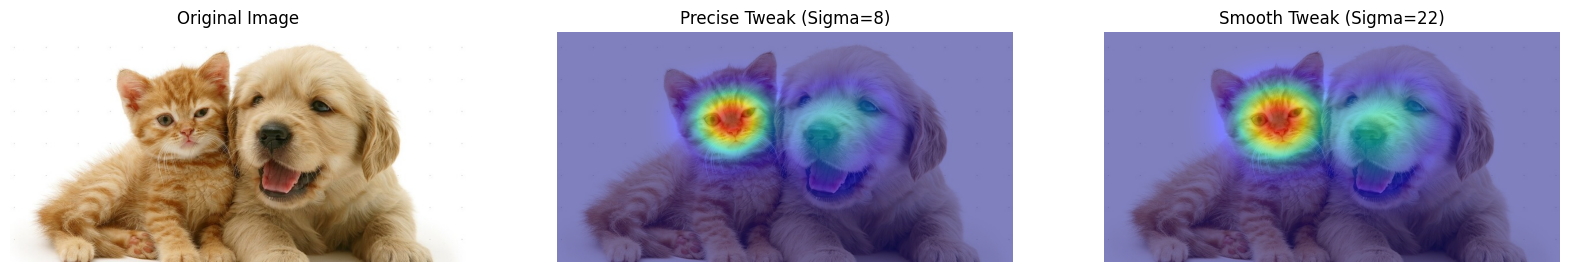